In [295]:
import numpy as np
import matplotlib.pyplot as plt

# Steering Vector from Cartesian Position

In [3]:

def nf_steering(tx_pos, rx_pos, wav_len):
    """
    Calculate the near field steering vector for a single transmitter-receiver pair from Cartesian positions.

    Parameters:
    tx_pos (numpy.ndarray): The position of the transmitter.
    rx_pos (numpy.ndarray): The position of the receiver.
    wav_len (float): The wavelength of the signal.

    Returns:
    complex: The near field steering vector.

    """
    range = np.linalg.norm(tx_pos - rx_pos)
    b = np.exp(-1j*2*np.pi/wav_len*range)
    return b

# Steering Vector for ULA from Polar Position 

In [604]:

def nf_steering_ULA_polar(theta, range, wav_len, n_ant, spacing_ratio = 0.5):
    """
    Calculate the near field steering vector for ULA from Polar positions.

    Parameters:
    tx_pos (numpy.ndarray): The position of the transmitter.
    rx_pos (numpy.ndarray): The position of the receiver.
    wav_len (float): The wavelength of the signal.
    n_ant (int): The number of antennas in the ULA.
    spacing_ratio (float): The ratio of the spacing between antennas to the wavelength.

    Returns:
    complex: The near field steering vector.

    """
    d = spacing_ratio * wav_len
    delta_vec = (2 * np.arange(n_ant) - n_ant) / 2
    r_vec = np.sqrt(np.power(range, 2) + \
            np.power(delta_vec, 2) * d**2 - \
            2 * range * delta_vec * d * np.cos(theta))
    b_vec = np.exp(-1j * 2 * np.pi/wav_len * r_vec)
    return b_vec

# nf steering vector using Fresnel approximation
def nf_steering_ULA_fresnel(theta, range, wav_len, n_ant, spacing_ratio = 0.5):
    """
    Calculate the near field steering vector for ULA from Polar positions, using Fresnel approximation.

    Parameters:
    tx_pos (numpy.ndarray): The position of the transmitter.
    rx_pos (numpy.ndarray): The position of the receiver.
    wav_len (float): The wavelength of the signal.
    n_ant (int): The number of antennas in the ULA.
    spacing_ratio (float): The ratio of the spacing between antennas to the wavelength.

    Returns:
    complex: The near field steering vector.

    """
    d = spacing_ratio * wav_len
    delta_vec = (2 * np.arange(n_ant) - n_ant) / 2
    r_vec = range - delta_vec * d * np.cos(theta) + (0.5 * 1/range) * np.power(delta_vec * d * np.sin(theta), 2)
    b_vec = np.exp(-1j * 2 * np.pi/wav_len * r_vec)
    return b_vec

def range_fresnel_approx(theta, range, wav_len, n_ant, spacing_ratio = 0.5):
    d = spacing_ratio * wav_len
    delta_vec = (2 * np.arange(n_ant) - n_ant) / 2
    r_vec = np.sqrt(np.power(range, 2) + \
            np.power(delta_vec, 2) * d**2 - \
            2 * range * delta_vec * d * np.cos(theta))
    fresnel_r_vec = range - delta_vec * d * np.cos(theta) + (0.5 * 1/range) * np.power(delta_vec * d * np.sin(theta), 2)
    
    return fresnel_r_vec, r_vec


# Error Evaluation from Fresnel Approximation

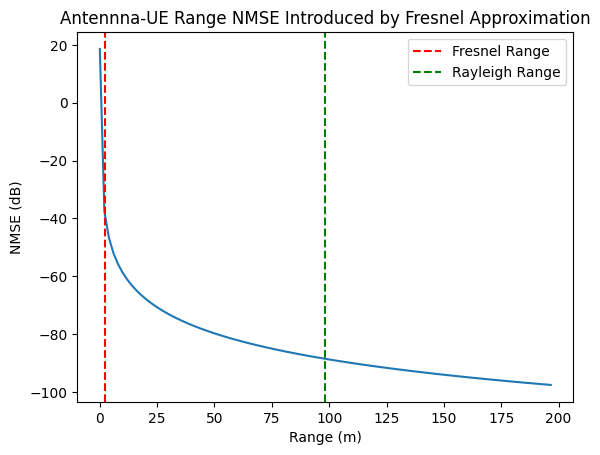

In [605]:
theta = np.pi/3 # UE theta
range = 10      # UE range

carrier_freq = 100 * 1e9
wav_len = 3 * 1e8 / carrier_freq
n_ant = 256
spacing_ratio = 0.5

D = n_ant * spacing_ratio * wav_len # array aperture
fresnel_range = 0.5 * np.sqrt(D ** 3 / wav_len) # Fresnel range
rayleigh_range = 2 * D**2 /  wav_len # Rayleigh range (NF-FF)

range_values = np.linspace(1e-5, 2, 100) * rayleigh_range
error_values = []

for rr in range_values:
    r_vec_fresnel, r_vec = range_fresnel_approx(theta, rr, wav_len, n_ant)
    NMSE_range = np.max(abs(r_vec_fresnel - r_vec) / r_vec)
    NMSE_range_db = 10 * np.log10(NMSE_range)
    error_values.append(NMSE_range_db)

plt.plot(range_values, error_values)
plt.axvline(x=fresnel_range, color='r', linestyle='--', label='Fresnel Range')
plt.axvline(x=rayleigh_range, color='g', linestyle='--', label='Rayleigh Range')
plt.xlabel('Range (m)')
plt.ylabel('NMSE (dB)')
plt.title('Antennna-UE Range NMSE Introduced by Fresnel Approximation')
plt.legend()
plt.show()


# Draw the $\mathbf{p}_u$ cost function
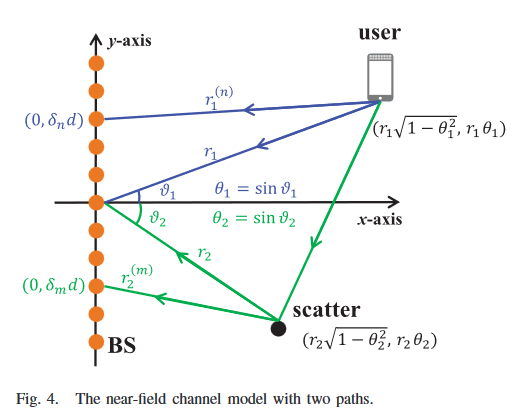

Weird phenomenon: 
1. maximize q(phi | y ) 's performance degrades a lot at (any x, y=0)
2. position y is far more sensitive to SNR than position x estimation

In [642]:
def V_func(p_u, kappa, miu, p_bs, wav_len, n_ant):
    V = 0
    for i in np.arange(n_ant):
        V += kappa[i] * np.cos( 2*np.pi/wav_len * np.linalg.norm(p_u - p_bs[i,:])  - miu[i])
        # V += kappa[i] * np.cos( 2*np.pi/wav_len * np.sqrt((p_u[0] - p_bs[i,0])**2+(p_u[1] - p_bs[i,1])**2)  - miu[i])
    return V


$V(\mathbf{p}_u)=\sum_{i=1}^M \hat{\kappa_i} \cos(\frac{2\pi}{\lambda} \Vert \mathbf{p}_u - \mathbf{p}_{BS,i} \Vert - \hat{\mu_i})$

In [669]:
n_ant = 128
carrier_freq = 100 * 1e9
wav_len = 3 * 1e8 / carrier_freq
spacing_ratio = 0.5

# antenna config
delta_vec = (2 * np.arange(n_ant) - n_ant) / 2
p_bs_x = np.zeros((n_ant, 1))
p_bs_y = np.expand_dims(delta_vec * spacing_ratio * wav_len, axis=-1) 
p_bs = np.concatenate((p_bs_x, p_bs_y), axis=1)

#
D = n_ant * spacing_ratio * wav_len # array aperture
fresnel_range = 0.5 * np.sqrt(D ** 3 / wav_len) # Fresnel range
rayleigh_range = 2 * D**2 / wav_len # Rayleigh range (NF-FF)
print(f"fresnel_range: {fresnel_range}, rayleigh_range: {rayleigh_range}")

fresnel_range: 0.768, rayleigh_range: 24.576



$q(\varphi_i | \mathbf{y}) \sim VM(\varphi_i; \hat{\mu_i}, \hat{\kappa_i})$

$\mathbb{E}_{q(\varphi_i | \mathbf{y})}[e^{j \varphi_i}] = \hat{\mu}_i$

In [686]:

# SNR and noise
SNR = 10 # (db)
sigma_n = 1 # (normalized) noise variance (^2)
sigma_rho = 1 * 10**(SNR/10) # (normalized by noise) variance of Gaussian rho pathloss prior (^2)

# channel vector
p_u_real = np.array([10,10])
r_vec =  np.array([np.linalg.norm(p_u_real - p_bs[i,:]) for i in np.arange(n_ant)])
print(np.mean(r_vec))
rho_vec = np.random.rand((n_ant)) * np.sqrt(sigma_rho)
h_vec = rho_vec * np.exp(-1j * 2*np.pi/wav_len * r_vec)

# received signal
n_vec = np.random.rand((n_ant)) * np.sqrt(sigma_n)
y_vec = h_vec + n_vec

# estimated model parameter

# initialization
sigma_rho_e = 1/ (1/sigma_n + 1/sigma_rho) # estimated variance of Gaussian q(rho|y)

phi_e_vec = np.angle(y_vec) # arg(E[e^(j*phi)]) = mu
rho_e_vec = sigma_rho_e/sigma_n * np.real(y_vec * np.exp(1j * phi_e_vec)) # estimated rho_i

mu_e_vec = np.angle(y_vec) # radian (-pi, pi] 
kappa_e_vec =  1/sigma_n  * np.abs(y_vec)  * rho_e_vec 



14.142720260700589


V_max at p_u[0]=251.0


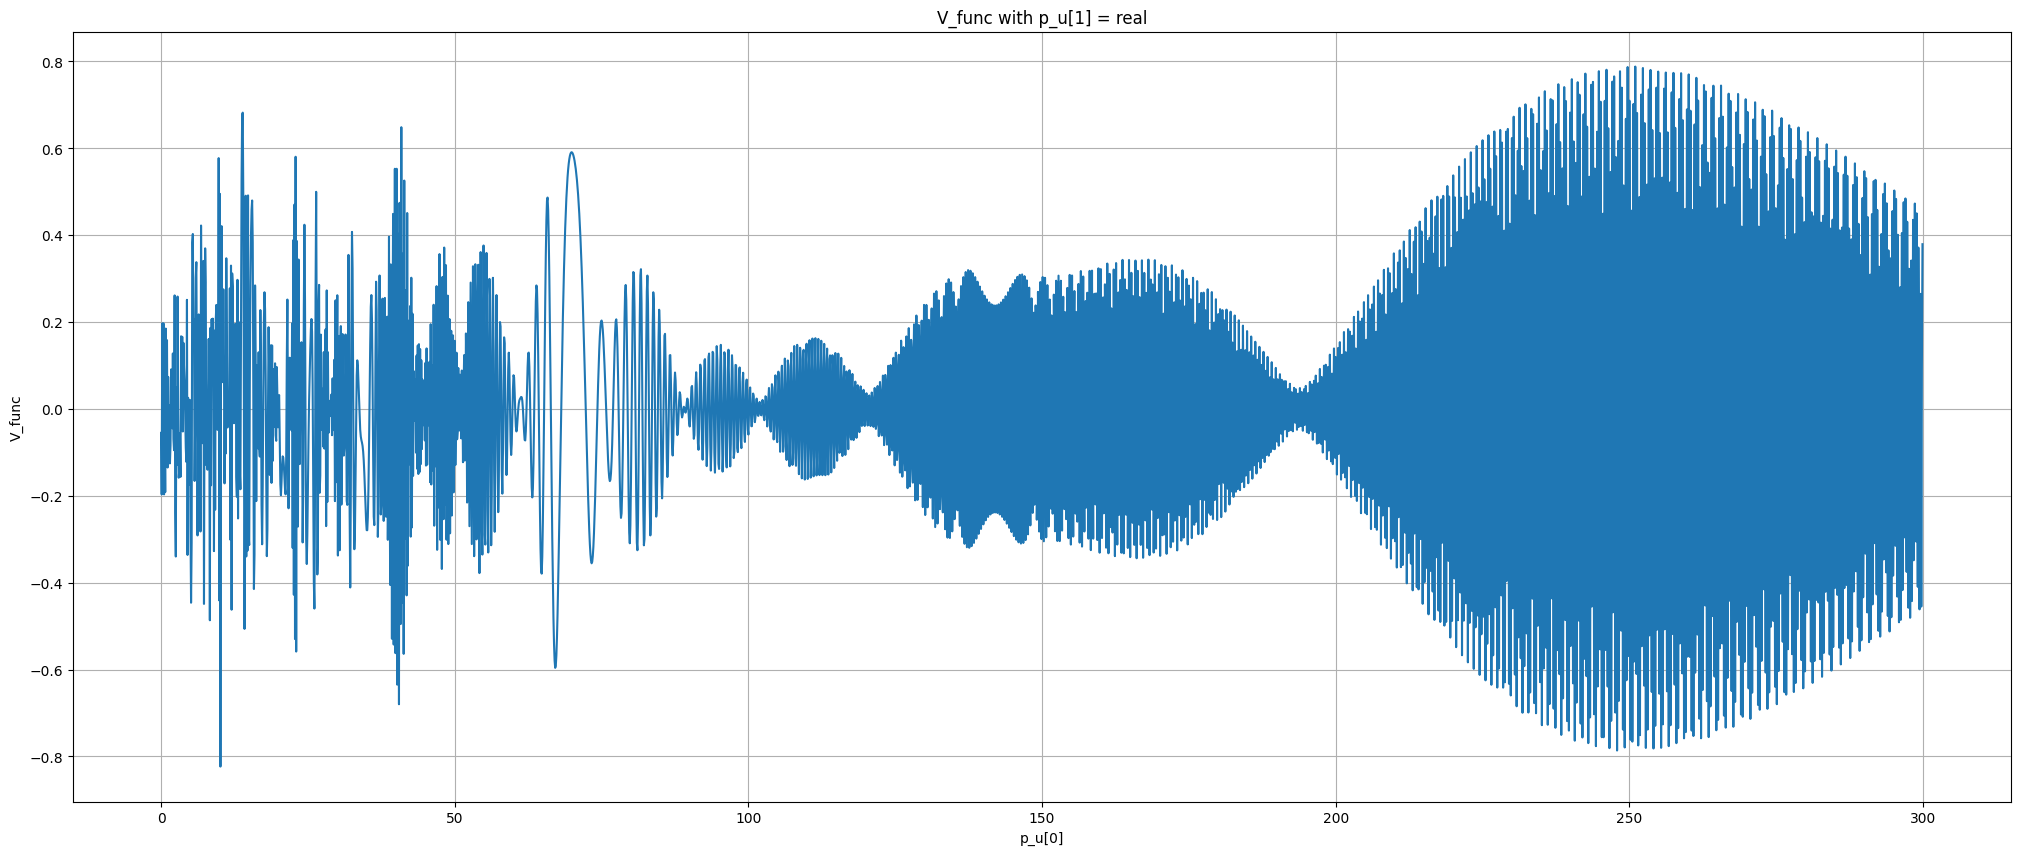

In [687]:
# Define the range for p_u[0]
stepsize = 0.1
start = 0
end = 300

p_u0_range = np.arange(start, end, stepsize)

# Set p_u[1] to 1
p_u1 = p_u_real[1]

# Calculate the V_func values for each p_u[0] value

V_values = []

for p_u0 in p_u0_range:
    p_u = np.array([p_u0, p_u1])
    V = V_func(p_u, kappa_e_vec, mu_e_vec, p_bs, wav_len, n_ant)
    V_values.append(V)

print(f"V_max at p_u[0]={np.argmax(V_values) * stepsize + start}")
# Plot the V_func values
plt.figure(figsize=(25, 10))
plt.plot(p_u0_range, V_values)
plt.xlabel('p_u[0]')
plt.ylabel('V_func')
plt.title('V_func with p_u[1] = real')
plt.grid(True)
plt.show()



V_max at p_u[1]=-1.3999999999999915


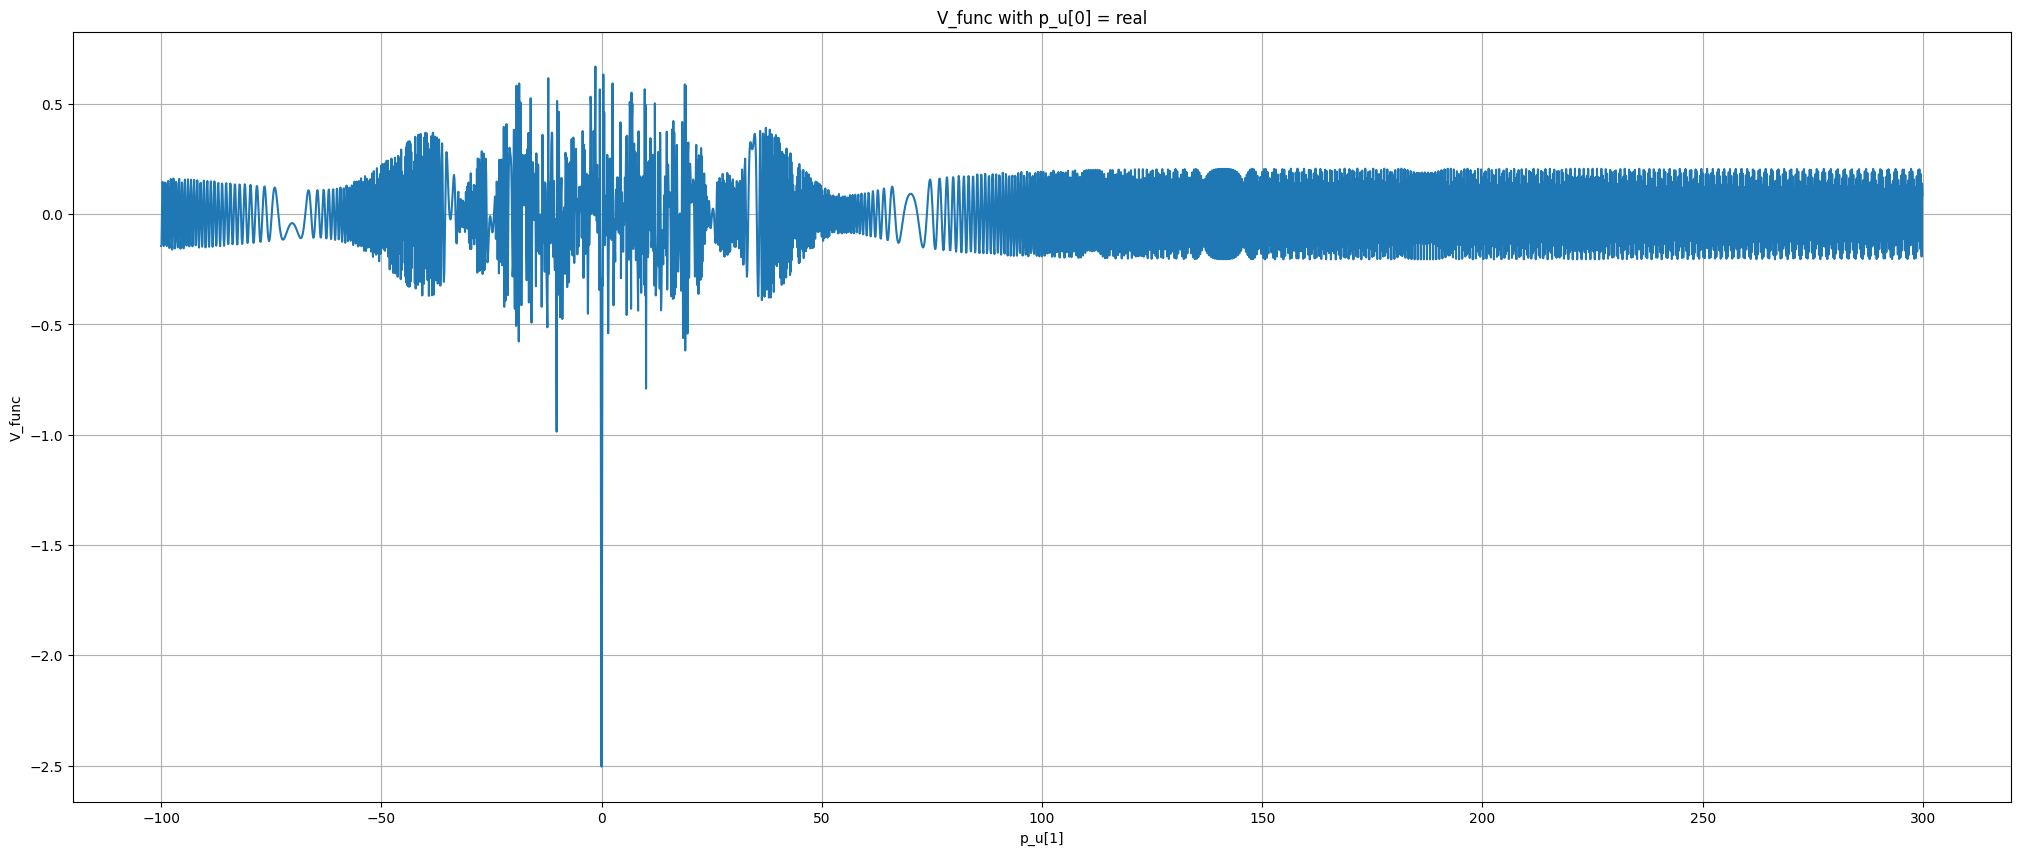

In [688]:
# Define the range for p_u[1]
stepsize = 0.1
start = -100
end = 300

p_u1_range = np.arange(start, end, stepsize)

# Set p_u[1] to 1
p_u0 = p_u_real[0]

# Calculate the V_func values for each p_u[0] value

V_values = []

for p_u1 in p_u1_range:
    p_u = np.array([p_u0, p_u1])
    V = V_func(p_u, kappa_e_vec, mu_e_vec, p_bs, wav_len, n_ant)
    V_values.append(V)

print(f"V_max at p_u[1]={np.argmax(V_values) * stepsize + start}")
# Plot the V_func values
plt.figure(figsize=(25, 10))
plt.plot(p_u1_range, V_values)
plt.xlabel('p_u[1]')
plt.ylabel('V_func')
plt.title('V_func with p_u[0] = real')
plt.grid(True)
plt.show()


# Gradient Ascent

In [524]:
import torch
import torch.nn as nn

In [665]:
def Loss(p_u, kappa, miu, p_bs, wav_len, n_ant):
    V = 0
    for i in np.arange(n_ant):
        V += - kappa[i] * torch.cos( 2*np.pi/wav_len * torch.norm(p_u - torch.tensor(p_bs[i,:]).unsqueeze(dim=-1))  - miu[i])
    return V


In [666]:
pos_e = nn.Parameter(torch.ones((2,1)), requires_grad=True)

optimizer = torch.optim.Adagrad([pos_e], lr=0.1)

running_loss = []

for i in np.arange(100):

    loss = Loss(pos_e, kappa_e_vec, mu_e_vec, p_bs, wav_len, n_ant)
    running_loss.append(loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()

In [668]:
nmse = np.abs((pos_e.detach().numpy() - np.expand_dims(p_u_real,-1)) / np.expand_dims(p_u_real,-1))
print(f"x,y NMSE (dB): {10 * np.log(nmse)}")

x,y NMSE (dB): [[-0.17854301]
 [-0.92689148]]


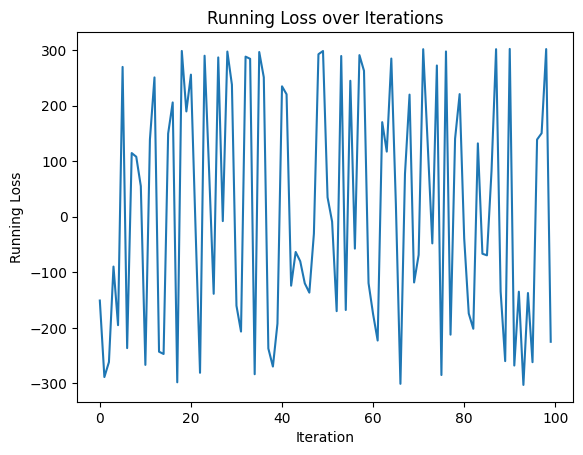

In [664]:
# Plotting the running loss
plt.plot(running_loss)
plt.xlabel('Iteration')
plt.ylabel('Running Loss')
plt.title('Running Loss over Iterations')
plt.show()